# PVBM Tutorial

## Import the libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize,square,dilation
import matplotlib.pyplot as plt

## Open a segmentation and extract its skeleton

In [3]:
segmentation_path = "117-793-749-000036_RR_43001_04734_F_48.png"

In [4]:
segmentation = Image.open(segmentation_path)

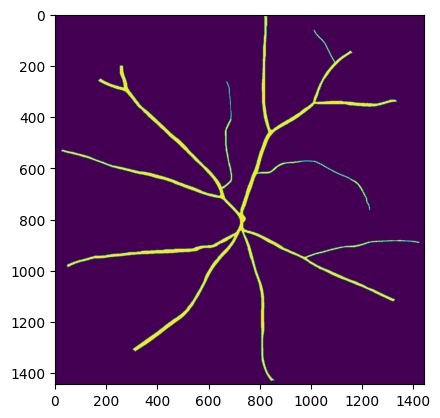

In [5]:
plt.imshow(segmentation)

In [6]:
segmentation = np.array(segmentation)

In [7]:
# Depending on the quality of the segmentation, you would need to regularize (smooth) it more or less 
#before computing the skeleton for instance by using the following command
segmentation_regularized = np.array(segmentation)/255#.filter(ImageFilter.ModeFilter(size=3)))/255
skeleton = skeletonize(segmentation_regularized)
segmentation = np.array(segmentation)/255

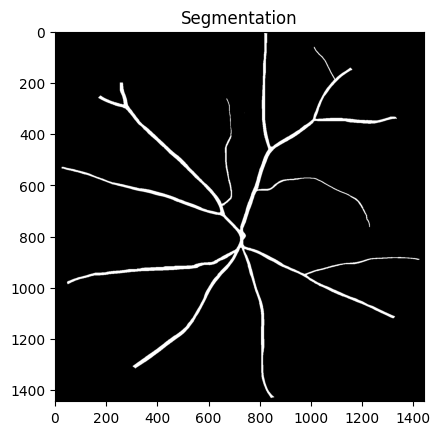

In [8]:
plt.imshow(segmentation,cmap = 'gray')
plt.title("Segmentation")
plt.show()

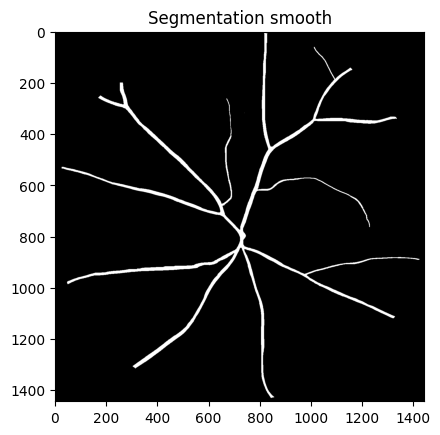

In [9]:
plt.imshow(segmentation_regularized,cmap = 'gray')
plt.title("Segmentation smooth")
plt.show()

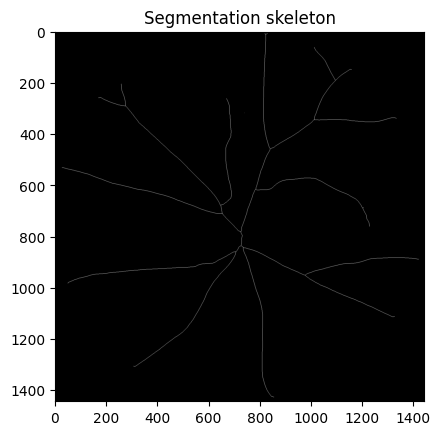

In [10]:
plt.imshow(skeleton,cmap = 'gray')
plt.title("Segmentation skeleton")
plt.show()

## Compute the area

In [11]:
from PVBM.GeometricalAnalysis import GeometricalVBMs
geometricalVBMs = GeometricalVBMs()

In [12]:
a = geometricalVBMs.area(segmentation)
print("The area is {}".format(a))

The area is 74718.0


## Compute the number of endpoints and intersection points, and display them

In [13]:
n_end,n_inter,end,inter = geometricalVBMs.compute_particular_points(skeleton)
print("There is {} endpoints and {} intersection points".format(n_end,n_inter))

There is 15 endpoints and 49 intersection points


In [14]:
end_dilated = dilation(end, square(10))
inter_dilated = dilation(inter, square(10))

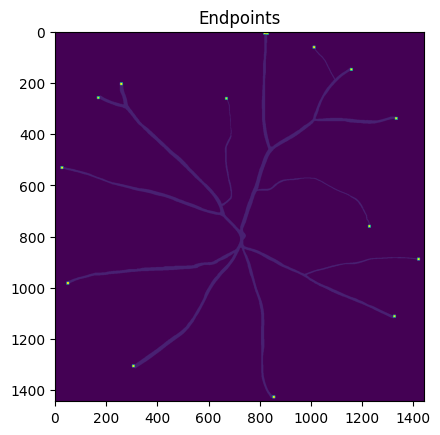

In [15]:
plt.imshow(segmentation/10+end_dilated)
plt.title('Endpoints')
plt.show()


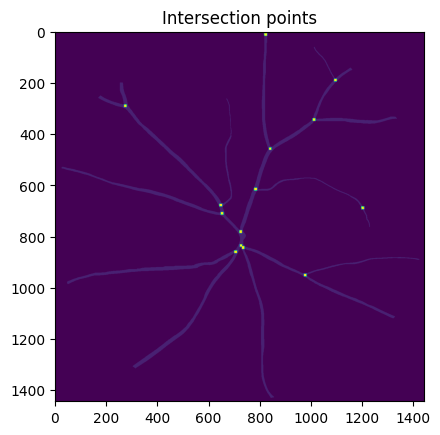

In [16]:
plt.imshow(segmentation/10+inter_dilated)
plt.title("Intersection points")
plt.show()


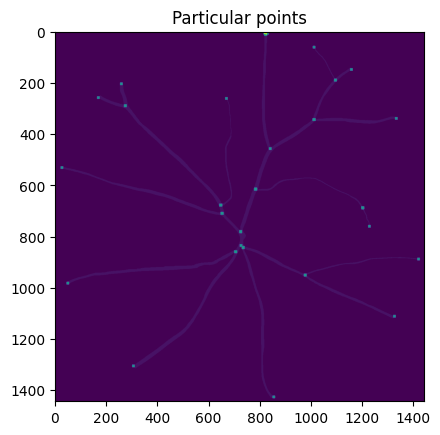

In [17]:
plt.imshow(segmentation/10+inter_dilated+end_dilated)
plt.title("Particular points")
plt.show()

## Compute the tortuosity and the length and display the linear interpolation between the particular points

In [23]:
median_tor, length,tor,l,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton) #times depends in the resolution of the segmentation (smaller is faster)

In [24]:
print("The median tortuosity is {}".format(median_tor))

The median tortuosity is 1.076613673789134


In [20]:
print("Here is the list containing the arc-chord ratio of every blood vessels (between two particular points) {}."
      .format(tor[:3]))
print("We can recompute the median tortuosity like this : {}".format(np.median(tor)))


Here is the list containing the arc-chord ratio of every blood vessels (between two particular points) [1.0326649560373642, 1.0644018448727424, 1.0737362316643277].
We can recompute the median tortuosity like this : 1.076613673789134


In [21]:
print("The length is {}".format(length))

The length is 7934.592780435798


In [22]:
print("Here is the list containing the length of every blood vessels (between two particular points) {}."
      .format(l[:3]))

Here is the list containing the length of every blood vessels (between two particular points) [2.8284271247461903, 6.242640687119285, 2].


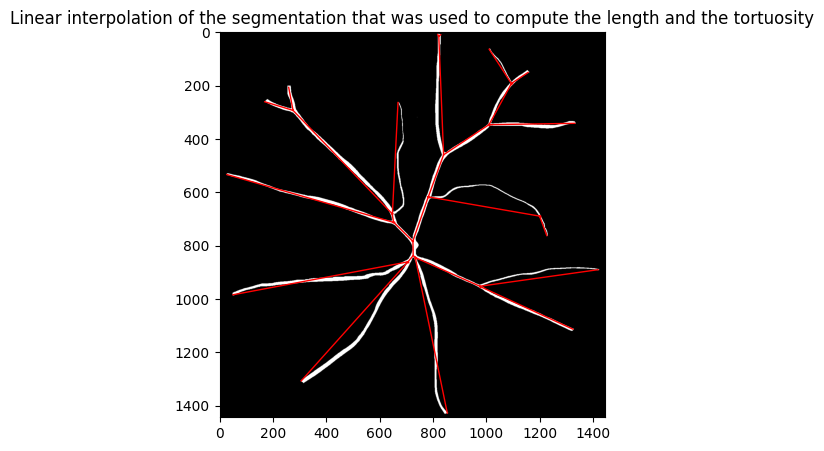

In [23]:
fig = plt.figure(figsize=(5,5))
for key,values in connection_dico.items():
    x1,y1 = key
    for value in values:
        x2,y2 = value[0][0],value[0][1]
        x_ = (x1,x2)
        y_ = (y1,y2)
        plt.plot(y_,x_, color="red", linewidth=1)
plt.imshow(segmentation,cmap = 'gray')
plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
plt.show()

## Compute the perimeter

In [24]:
p,border_matrix = geometricalVBMs.compute_perimeter(segmentation.T) #times depends in the resolution of the segmentation (smaller is faster)

In [25]:
print("The perimeter is {}".format(p))

The perimeter is 16263.704463579805


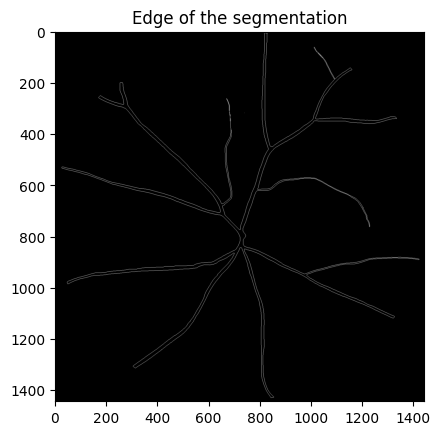

In [26]:
plt.imshow(border_matrix,cmap = "gray")
plt.title("Edge of the segmentation")
plt.show()

## Branching angles

In [27]:
mean_ba,std_ba,median_ba,angle_dico,centroid = geometricalVBMs.compute_branching_angles(skeleton)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

/Users/jonathanfhima/Desktop/PVBMRelease/PVBM/helpers/branching_angle.py:151: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))


In [28]:
mean_ba,std_ba,median_ba

(93.68170612379406, 37.730154406140876, 81.38508303417835)

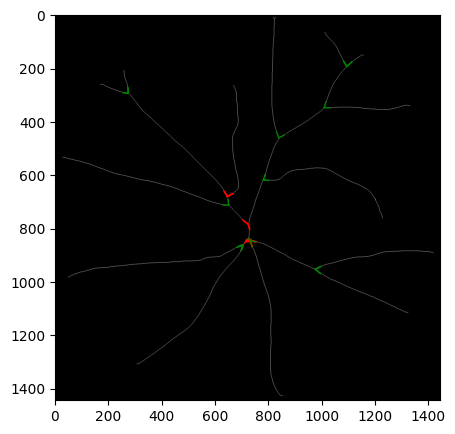

In [29]:
fig = plt.figure(figsize=(5,5))
for points,angle in angle_dico.items():
    b,a,c = points
    if True:
        if angle > 90 :
            x_ = [b[0],a[0]]
            y_ = [b[1],a[1]]
            plt.plot(y_,x_, color="red", linewidth=1)
            x_ = [b[0],c[0]]
            y_ = [b[1],c[1]]
            plt.plot(y_,x_, color="red", linewidth=1)
        if angle < 90 :
            x_ = [b[0],a[0]]
            y_ = [b[1],a[1]]
            plt.plot(y_,x_, color="green", linewidth=1)
            x_ = [b[0],c[0]]
            y_ = [b[1],c[1]]
            plt.plot(y_,x_, color="green", linewidth=1)
plt.imshow(skeleton,cmap = 'gray')
plt.show()

### The centroid can also be ploted (independent for each subgraph)

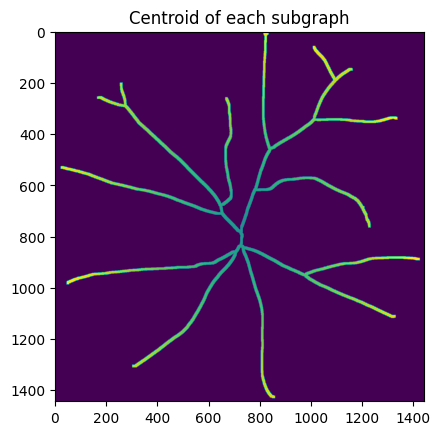

In [30]:
plt.imshow(dilation(centroid,square(10)))
plt.title("Centroid of each subgraph")
plt.show()

### Lets extract each subgraph and their centroid

In [31]:
graphs = 1*(centroid != -1)

In [32]:
from queue import PriorityQueue
def iterative(A, B, i, j, n):
  pq = PriorityQueue()
  pq.put((0,A,B,i,j,n))
  priotities = [0,1,2,3,4,5,6,7]
  while not pq.empty():
    _,A, B, i, j, n = pq.get()
    directions = [(i-1,j),(i+1,j),(i,j-1),(i,j+1),(i-1,j-1),(i-1,j+1),(i+1,j-1),(i+1,j+1)]
    for direction,priority in zip(directions,priotities):
      x,y = direction
      if x >= 0 and x < A.shape[0] and y >= 0 and y < A.shape[1] and A[direction] == 1:
            B[direction] = n
            A[direction] = 0
            pq.put((priority,A,B,direction[0],direction[1],n))


In [33]:
from tqdm.notebook import tqdm
def extract_subgraphs(graphs):
    B = np.zeros_like(graphs)
    n = 1
    for i in tqdm(range(graphs.shape[0])):
        for j in range(graphs.shape[1]):
            if B[i,j] == 0 and graphs[i,j] == 1:
                iterative(graphs,B,i,j,n)
                n+=1
    return B
    
    

In [34]:
B = extract_subgraphs(graphs.copy())

  0%|          | 0/1444 [00:00<?, ?it/s]

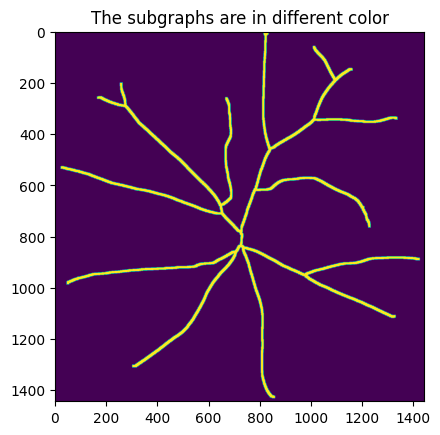

In [35]:
plt.imshow(dilation(B*100,square(10)))
plt.title("The subgraphs are in different color")
plt.show()

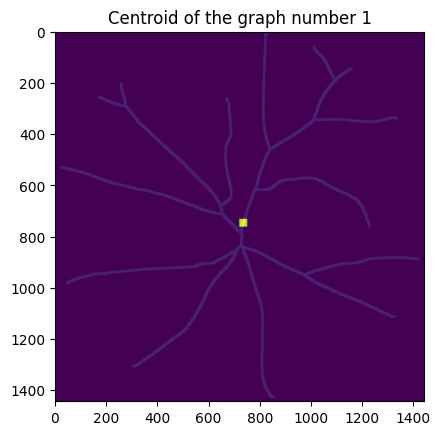

In [36]:
for i in range(1,B.max()+1):
    mask = B == i
    sub_skeleton = skeleton * mask
    sub_centroid = centroid * mask
    sub_centroid_tmp = sub_centroid.copy()
    sub_centroid_tmp[sub_centroid_tmp == 0 ] = np.inf
    detected_centroid = sub_centroid_tmp == sub_centroid_tmp.min()
    plt.imshow(dilation(sub_skeleton,square(10)) + 10*dilation(detected_centroid,square(30)))
    plt.title("Centroid of the graph number {}".format(i))
    plt.show()
    

## Fractal Analysis

In [37]:
from PVBM.FractalAnalysis import MultifractalVBMs
fractalVBMs = MultifractalVBMs(n_rotations = 25,optimize = True, min_proba = 0.0001, maxproba = 0.9999)

In [38]:
D0,D1,D2,SL = fractalVBMs.get_fundus_biomarkers(segmentation)

In [39]:
print("The fractal biomarkers are D0: {}, D1: {}, D2: {}, SL: {}".format(D0,D1,D2,SL))

The fractal biomarkers are D0: 1.3108560242559306, D1: 1.2990298019085615, D2: 1.2969899646342158, SL: 0.7232841382079696
